In [75]:
##Posydon V1
from mpi4py import MPI
from posydon.popsyn.binarypopulation import BinaryPopulation
from posydon.binary_evol import SimulationProperties
from posydon.binary_evol.flow_chart import flow_chart
from posydon.binary_evol.MESA.step_mesa import CO_HeMS_step, MS_MS_step, CO_HMS_RLO_step
from posydon.binary_evol.DT.step_detached import detached_step
from posydon.binary_evol.CE.step_CEE import StepCEE
from posydon.binary_evol.SN.step_SN import StepSN
from posydon.binary_evol.DT.double_CO import DoubleCO
from posydon.binary_evol.step_end import step_end
from posydon.binary_evol.simulationproperties import StepNamesHooks

# STEP CUSTOMISATION
MESA_STEP = dict(
    interpolation_path = None, # found by default
    interpolation_filename = None, # found by default
    interpolation_method = 'linear3c_kNN', # 'nearest_neighbour' 'linear3c_kNN' '1NN_1NN'
    save_initial_conditions = True, # only for interpolation_method='nearest_neighbour'
    track_interpolation = False, # True False
    stop_method = 'stop_at_max_time', # 'stop_at_end' 'stop_at_max_time' 'stop_at_condition'
    stop_star = 'star_1', # only for stop_method='stop_at_condition' 'star_1' 'star_2'
    stop_var_name = None, # only for stop_method='stop_at_condition' str
    stop_value = None, # only for stop_method='stop_at_condition' float
    stop_interpolate = True, # True False
    verbose = False, # True False
)

DETACHED_STEP = dict(
    matching_method = 'minimize', #'minimize' 'root'
    do_wind_loss = True, # True False
    do_tides = True,  # True False
    do_gravitational_radiation = True,  # True False
    do_magnetic_braking = True,  # True False
    do_stellar_evolution_and_spin_from_winds = True,  # True False
    RLO_orbit_at_orbit_with_same_am = False,  # True False
    verbose = False,  # True False
)

CE_STEP = dict(
    prescription='alpha-lambda', # 'alpha-lambda'
    common_envelope_efficiency=1.0, # float in (0, inf)
    common_envelope_option_for_lambda='lambda_from_grid_final_values', # (1) 'default_lambda', (2) 'lambda_from_grid_final_values',
                                                  # (3) 'lambda_from_profile_gravitational',
                                                  # (4) 'lambda_from_profile_gravitational_plus_internal',
                                                  # (5) 'lambda_from_profile_gravitational_plus_internal_minus_recombination'
    common_envelope_lambda_default=0.5, # float in (0, inf) used only for option (1)
    common_envelope_option_for_HG_star="optimistic", # 'optimistic', 'pessimistic'
    common_envelope_alpha_thermal=1.0, # float in (0, inf) used only for option for (4), (5)
    core_definition_H_fraction=0.1, # 0.01, 0.1, 0.3
    core_definition_He_fraction=0.1, # 0.1
    CEE_tolerance_err=0.001, # float (0, inf)
    common_envelope_option_after_succ_CEE = 'core_not_replaced_noMT', # 'core_not_replaced_noMT' 'core_replaced_noMT' 'core_not_replaced_stableMT' 'core_not_replaced_windloss'
    verbose = False, # True False
)

SN_STEP = dict(
    mechanism='Patton&Sukhbold20-engine', # 'direct', Fryer+12-rapid', 'Fryer+12-delayed', 'Sukhbold+16-engine', 'Patton&Sukhbold20-engine'
    engine='N20', # 'N20' for 'Sukhbold+16-engine', 'Patton&Sukhbold20-engine' or None for the others
    PISN="Marchant+19", # None, "Marchant+19"
    ECSN="Podsiadlowksi+04", # "Tauris+15", "Podsiadlowksi+04"
    max_neutrino_mass_loss=0.5, # float (0,inf)
    kick=True, # True, False
    kick_normalisation='one_over_mass', # "one_minus_fallback", "one_over_mass", "NS_one_minus_fallback_BH_one", "one", "zero"
    sigma_kick_CCSN_NS=265.0, # float (0,inf)
    sigma_kick_CCSN_BH=265.0, # float (0,inf)
    sigma_kick_ECSN=20.0, # float (0,inf)
    max_NS_mass=2.5,  # float (0,inf)
    use_interp_values=True,  # True, False
    use_profiles=True,  # True, False
    use_core_masses=True,  # True, False
    approx_at_he_depletion=True, # True, False
    verbose = False,  # True False
)

DCO_STEP = dict(
    n_o_steps_interval = None,
)

END_STEP = {}

# FLOW CHART CONFIGURATION
sim_kwargs = dict(
    flow = (flow_chart, {}),
    step_HMS_HMS = (MS_MS_step, MESA_STEP),
    step_CO_HeMS = (CO_HeMS_step, MESA_STEP),
    step_CO_HMS_RLO = (CO_HMS_RLO_step, MESA_STEP),
    step_detached = (detached_step, DETACHED_STEP),
    step_CE = (StepCEE, CE_STEP),
    step_SN = (StepSN, SN_STEP),
    step_dco = (DoubleCO, DCO_STEP),
    step_end = (step_end, END_STEP),
    extra_hooks = [(StepNamesHooks, {})]
)

sim_prop = SimulationProperties(**sim_kwargs)

# SIMULATION CONFIGURATION
kwargs = dict(
    file_path='./batches/',
    optimize_ram=True,
    ram_per_cpu=3., # limit ram usage at 3GB
    dump_rate=10000, # limit batch size

    metallicity = 0.0001,
    number_of_binaries=40, # int
    star_formation='burst', # 'constant' 'burst' 'custom_linear' 'custom_log10' 'custom_linear_histogram' 'custom_log10_histogram'
    max_simulation_time=13.8e9, # float (0,inf)

    primary_mass_scheme='Kroupa2001', # 'Salpeter', 'Kroupa1993', 'Kroupa2001'
    primary_mass_min=10, # float (0,130)
    primary_mass_max=25., # float (0,130)
    secondary_mass_scheme='flat_mass_ratio', # 'flat_mass_ratio', 'q=1'
    secondary_mass_min=1, # float (0,130)
    secondary_mass_max=2., # float (0,130)
    orbital_scheme = 'period', # 'separation', 'period'
    orbital_period_scheme = 'Sana+12_period_extended', # used only for orbital_scheme = 'period'
    orbital_period_min = 1., # float (0,inf)
    orbital_period_max = 100., # float (0,inf)
    #orbital_separation_scheme='log_uniform', # used only for orbital_scheme = 'separation', 'log_uniform', 'log_normal'
    #orbital_separation_min=5., # float (0,inf)
    #orbital_separation_max=1e5, # float (0,inf)
    #log_orbital_separation_mean=None, # float (0,inf) used only for orbital_separation_scheme ='log_normal'
    #log_orbital_separation_sigma=None, # float (0,inf) used only for orbital_separation_scheme ='log_normal'
    eccentricity_sche='zero', # 'zero' 'thermal' 'uniform'

    # IMPORT CUSTOM HOOKS
    extra_columns=['step_names'], # 'step_times' with from posydon.binary_evol.simulationproperties import TimingHooks

    # LIST BINARY PROPERTIES TO SAVE
    only_select_columns=[
                        'state',
                        'event',
                        'time',
                        #'separation',
                        'orbital_period',
                        'eccentricity',
                        #'V_sys',
                        #'rl_relative_overflow_1',
                        #'rl_relative_overflow_2',
                        'lg_mtransfer_rate',
                        #'mass_transfer_case',
                        #'trap_radius',
                        #'acc_radius',
                        #'t_sync_rad_1',
                        #'t_sync_conv_1',
                        #'t_sync_rad_2',
                        #'t_sync_conv_2',
                        #'nearest_neighbour_distance',
                        ],

    # LIST STAR PROPERTIES TO SAVE
    include_S1=True , # True, False
    S1_kwargs=dict(only_select_columns=[
                                        'state',
                                        #'metallicity',
                                        'mass',
                                        'log_R',
                                        'log_L',
                                        'lg_mdot',
                                        #'lg_system_mdot',
                                        #'lg_wind_mdot',
                                        'he_core_mass',
                                        'he_core_radius',
                                        #'c_core_mass',
                                        #'c_core_radius',
                                        #'o_core_mass',
                                        #'o_core_radius',
                                        'co_core_mass',
                                        'co_core_radius',
                                        'center_h1',
                                        'center_he4',
                                        #'center_c12',
                                        #'center_n14',
                                        #'center_o16',
                                        'surface_h1',
                                        'surface_he4',
                                        #'surface_c12',
                                        #'surface_n14',
                                        #'surface_o16',
                                        #'log_LH',
                                        #'log_LHe',
                                        #'log_LZ',
                                        #'log_Lnuc',
                                        #'c12_c12',
                                        #'center_gamma',
                                        #'avg_c_in_c_core',
                                        #'surf_avg_omega',
                                        'surf_avg_omega_div_omega_crit',
                                        #'total_moment_of_inertia',
                                        #'log_total_angular_momentum',
                                        'spin',
                                        #'conv_env_top_mass',
                                        #'conv_env_bot_mass',
                                        #'conv_env_top_radius',
                                        #'conv_env_bot_radius',
                                        #'conv_env_turnover_time_g',
                                        #'conv_env_turnover_time_l_b',
                                        #'conv_env_turnover_time_l_t',
                                        #'envelope_binding_energy',
                                        #'mass_conv_reg_fortides',
                                        #'thickness_conv_reg_fortides',
                                        #'radius_conv_reg_fortides',
                                        #'lambda_CE_1cent',
                                        #'lambda_CE_10cent',
                                        #'lambda_CE_30cent',
                                        #'lambda_CE_pure_He_star_10cent',
                                        #'profile',
                                        ],
                   scalar_names=['natal_kick_array',
                                 'SN_type',
                                 #'f_fb',
                                 #'spin_orbit_tilt',
                                ]),

    # LIST STAR PROPERTIES TO SAVE
    include_S2=True, # True, False
    S2_kwargs=dict(only_select_columns=[
                                        'state',
                                        #'metallicity',
                                        'mass',
                                        'log_R',
                                        'log_L',
                                        'lg_mdot',
                                        #'lg_system_mdot',
                                        #'lg_wind_mdot',
                                        'he_core_mass',
                                        'he_core_radius',
                                        #'c_core_mass',
                                        #'c_core_radius',
                                        #'o_core_mass',
                                        #'o_core_radius',
                                        'co_core_mass',
                                        'co_core_radius',
                                        'center_h1',
                                        'center_he4',
                                        #'center_c12',
                                        #'center_n14',
                                        #'center_o16',
                                        'surface_h1',
                                        'surface_he4',
                                        #'surface_c12',
                                        #'surface_n14',
                                        #'surface_o16',
                                        #'log_LH',
                                        #'log_LHe',
                                        #'log_LZ',
                                        #'log_Lnuc',
                                        #'c12_c12',
                                        #'center_gamma',
                                        #'avg_c_in_c_core',
                                        #'surf_avg_omega',
                                        'surf_avg_omega_div_omega_crit',
                                        #'total_moment_of_inertia',
                                        #'log_total_angular_momentum',
                                        'spin',
                                        #'conv_env_top_mass',
                                        #'conv_env_bot_mass',
                                        #'conv_env_top_radius',
                                        #'conv_env_bot_radius',
                                        #'conv_env_turnover_time_g',
                                        #'conv_env_turnover_time_l_b',
                                        #'conv_env_turnover_time_l_t',
                                        #'envelope_binding_energy',
                                        #'mass_conv_reg_fortides',
                                        #'thickness_conv_reg_fortides',
                                        #'radius_conv_reg_fortides',
                                        #'lambda_CE_1cent',
                                        #'lambda_CE_10cent',
                                        #'lambda_CE_30cent',
                                        #'lambda_CE_pure_He_star_10cent',
                                        #'profile',
                                        ],
                   scalar_names=['natal_kick_array',
                                 'SN_type',
                                 #'f_fb',
                                 #'spin_orbit_tilt',
                                ]),
)

def run_simulation(sim_prop, kwargs, file=None, indices=None, use_MPI=False):

    if not use_MPI:
        # create binaries
        pop = BinaryPopulation(entropy=None,
                               population_properties=sim_prop,
                               file_name=file,
                               **kwargs)
    else:
        comm = MPI.COMM_WORLD
        rank = comm.Get_rank()
        size = comm.Get_size()

        # create binaries
        pop = BinaryPopulation(entropy=None,
                                   population_properties=sim_prop,
                                   file_name=file,
                                   comm=comm,
                                   **kwargs)
        sim_prop.load_steps(verbose=True)

    # evolve binaries
    if file is not None:
        kwargs['from_hdf'] = True
        kwargs['indices'] = indices

    pop.evolve(breakdown_to_df=False, tqdm=True, **kwargs)

    # save binaries
    pop.save('./population.h5', **kwargs)

    return pop

if __name__ == '__main__' :
    pop = run_simulation(sim_prop, kwargs, use_MPI=False)

100%|██████████| 40/40 [01:33<00:00,  2.35s/it]


Traceback (most recent call last):
  File "/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/io/pytables.py", line 4065, in _get_blocks_and_items
    b, b_items = by_items.pop(items)
KeyError: ('FAILED', 'WARNING')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/fs/lustre/scratch/RAID-CITA/claireshiye/POSYDON/posydon/popsyn/binarypopulation.py", line 372, in combine_saved_files
    min_itemsize=oneline_min_itemsize)
  File "/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/io/pytables.py", line 1278, in append
    errors=errors,
  File "/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/io/pytables.py", line 1785, in _write_to_group
    track_times=track_times,
  File "/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/pandas/io/pytables.py", line 4299, in wri

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import unit_convert as uc

savepath = '/fs/lustre/cita/claireshiye/projects/posydon/'

In [68]:
from posydon.binary_evol.singlestar import SingleStar
from posydon.binary_evol.binarystar import BinaryStar
sim_prop.load_steps(verbose=True)

sep = uc.period_to_au(10., 1.3, 2)*215.032
binary = BinaryStar(star_1 = SingleStar(**{'mass' : 1.3,
                                           'state' : 'NS',
                                           'natal_kick_array' : [0, 0., 0., 0.]}),
                    star_2 = SingleStar(**{'mass' : 2,
                                           'state' : 'H-rich_Core_H_burning',
                                           'natal_kick_array' : [0., 0., 0., 0.]}),
                    **{'time' : 0.,
                       'state' : 'detached',
                        'event' : None,
                       'orbital_period' : 10.,
                       'separation': sep,
                       'eccentricity' : 0.},
                    properties = sim_prop,
                    )
binary.evolve()
#cols = ['state', 'event','time','orbital_period', 'eccentricity', 'S1_state', 'S2_state', 'S1_mass', 'S2_mass']
bin_df = binary.to_df()#[cols]
#print(bin_df['state'], bin_df.iloc[:,0])
bin_df.to_hdf('binary.h5', key = 'history', mode='w')

STEP NAME           STEP FUNCTION            KWARGS
flow (<function flow_chart at 0x14a0c63a03b0>, {})
step_HMS_HMS (<class 'posydon.binary_evol.MESA.step_mesa.MS_MS_step'>, {'interpolation_path': None, 'interpolation_filename': None, 'interpolation_method': 'linear3c_kNN', 'save_initial_conditions': True, 'track_interpolation': False, 'stop_method': 'stop_at_max_time', 'stop_star': 'star_1', 'stop_var_name': None, 'stop_value': None, 'stop_interpolate': True, 'verbose': False})
step_CO_HeMS (<class 'posydon.binary_evol.MESA.step_mesa.CO_HeMS_step'>, {'interpolation_path': None, 'interpolation_filename': None, 'interpolation_method': 'linear3c_kNN', 'save_initial_conditions': True, 'track_interpolation': False, 'stop_method': 'stop_at_max_time', 'stop_star': 'star_1', 'stop_var_name': None, 'stop_value': None, 'stop_interpolate': True, 'verbose': False})
step_CO_HMS_RLO (<class 'posydon.binary_evol.MESA.step_mesa.CO_HMS_RLO_step'>, {'interpolation_path': None, 'interpolation_filename':

/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  old_joblib = LooseVersion(joblib_version) < LooseVersion('0.12')
/mnt/raid-cita/claireshiye/opt/anaconda3/envs/posydon-git/lib/python3.7/site-packages/sklearn/neighbors/base.py:441: DeprecationWarning: distutils Version classes are de

In [70]:
from posydon.visualization.VHdiagram import VHdiagram

VHdiagram('binary.h5', index=0)

KeyError: 0

In [ ]:
from posydon.visualization.VHdiagram import VHdiagram
from posydon.visualization.VH_diagram.PresenterMode import PresenterMode

VHdiagram('population.h5', index=1, presentMode=PresenterMode.DIAGRAM)

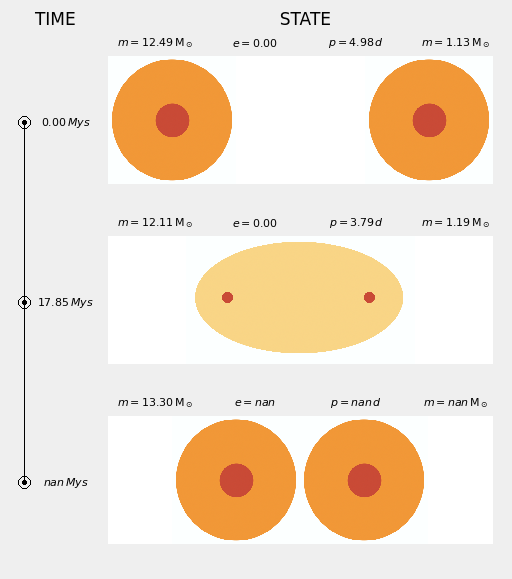

In [80]:
from posydon.visualization.VHdiagram import VHdiagram, DisplayMode
from posydon.visualization.VH_diagram.Presenter import PresenterMode

VHdiagram(
    "population.h5",
    index=30,
    presentMode=PresenterMode.DIAGRAM,
    displayMode=DisplayMode.INLINE_B)